In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

2023-10-08 10:48:44.254958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 10:48:44.255011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 10:48:44.255040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 10:48:44.264389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



## PINN as PDE solver (no data)

### Define Parameters

In [3]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

### Define PDE with Boundary Conditions

In [4]:
def pde(X, Y):
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    du_xy = dde.grad.hessian(Y, X, component=0, i=0, j=1)

    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    dv_xy = dde.grad.hessian(Y, X, component=1, i=0, j=1)

    force_eq_x = (du_xx + 0.5*(1-nu)*du_yy + 0.5*(1+nu)*dv_xy)*E/(1-nu**2)
    force_eq_y = (dv_yy + 0.5*(1-nu)*dv_xx + 0.5*(1+nu)*du_xy)*E/(1-nu**2)

    return [force_eq_x, force_eq_y]

In [5]:
def boundary_x(X, on_boundary):
    return on_boundary and np.isclose(X[0], a)

def boundary_y(X, on_boundary):
    return on_boundary and np.isclose(X[1], b)

def boundary_x0(X, on_boundary):
    return on_boundary and np.isclose(X[0], 0)

def boundary_y0(X, on_boundary):
    return on_boundary and np.isclose(X[1], 0)

def BC_xy(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)

    sig_xx = (du_x + nu*dv_y)*E/(1-nu**2)
    sig_yy = (dv_y + nu*du_x)*E/(1-nu**2)
    sig_xy = (dv_x + du_y)*E/(1+nu)/2

    sig_ex = f * h * tf.reshape(tf.math.cos(np.pi / (2 * b) * X[:, 1]), [-1, 1])

    return sig_xx-sig_ex, sig_xy, sig_yy

### Define Geometry and Implement Boundary Conditions

In [6]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])

bc_Y0 = dde.DirichletBC(geom, lambda x: 0, boundary_y0, component=1)
bc_X0 = dde.DirichletBC(geom, lambda x: 0, boundary_x0, component=0)

bc_free_yy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[2], boundary_y)
bc_free_yx = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_y)

bc_traction = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[0], boundary_x)
bc_free_xy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_x)

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_Y0, bc_X0, bc_free_yy, bc_free_yx, bc_traction, bc_free_xy],
                    num_domain=9000,
                    num_boundary=1000,
                    num_test=100)

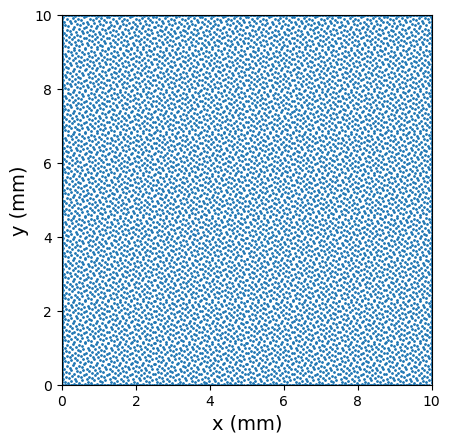

In [9]:
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=1)
plt.xlabel('x (mm)', fontsize = 14)
plt.ylabel('y (mm)', fontsize = 14)
plt.axis('square')
plt.xlim([0, a])
plt.ylim([0, b])
plt.show()

### Define Network and Hyper-parameters

In [10]:
layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

2023-10-08 10:49:42.971669: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-08 10:49:42.972616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [11]:
model = dde.Model(data, net)

In [12]:
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.008956 s



### Train (Adam Optimizer)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x7f4e0e7892d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4e0e7892d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4e0e789630>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4e0e789630>: no matc

2023-10-08 10:49:53.412451: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a1bbcaac00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 10:49:53.412505: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-08 10:49:53.454505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 10:49:54.251963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 10:49:54.270605: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-08 10:49:55.270904: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.39e+01, 1.36e+00, 1.85e-01, 7.50e-01, 4.45e+00, 1.64e+00, 1.05e+01, 5.81e-01]    [1.34e+01, 1.48e+00, 1.85e-01, 7.50e-01, 4.45e+00, 1.64e+00, 1.05e+01, 5.81e-01]    []  
100       [8.13e-03, 2.10e-03, 2.28e-04, 1.15e-03, 3.37e-04, 3.82e-04, 8.55e-04, 8.39e-04]    [6.73e-03, 2.26e-03, 2.28e-04, 1.15e-03, 3.37e-04, 3.82e-04, 8.55e-04, 8.39e-04]    []  
200       [4.13e-03, 8.59e-04, 1.12e-04, 7.49e-04, 1.36e-04, 1.33e-04, 4.30e-04, 3.21e-04]    [3.58e-03, 8.51e-04, 1.12e-04, 7.49e-04, 1.36e-04, 1.33e-04, 4.30e-04, 3.21e-04]    []  
300       [2.47e-03, 6.20e-04, 6.31e-05, 5.20e-04, 9.40e-05, 8.50e-05, 2.98e-04, 2.23e-04]    [2.11e-03, 5.96e-04, 6.31e-05, 5.20e-04, 9.40e-05, 8.50e-05, 2.98e-04, 2.23e-04]    []  
400       [1.74e-03, 5.69e-04, 5.10e-05, 3.70e-04, 8.45e-05, 6.93e-05, 2.52e-0

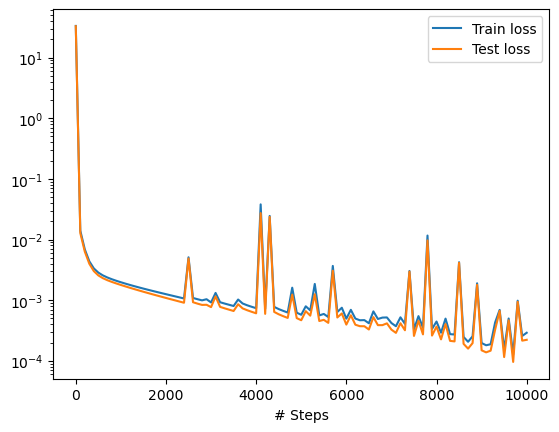

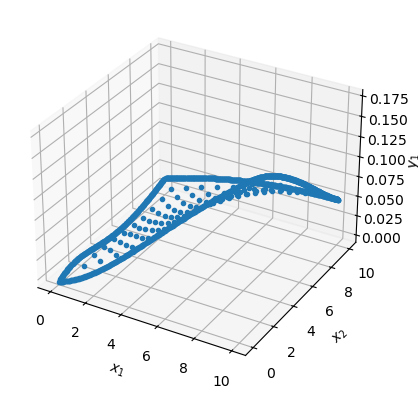

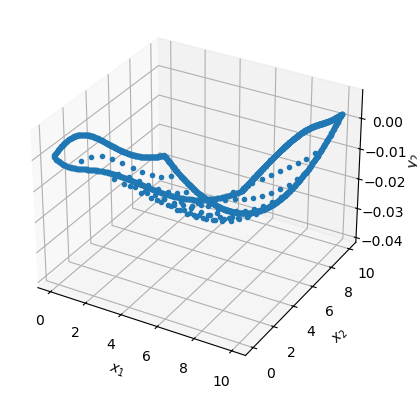

In [13]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

### Plot Results (Adam Optimizer)

In [14]:
def check_stress(net, X):
    X = tf.constant(X)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        disp = net(X)
        u_pred = tf.reshape(disp[:, 0], [-1, 1])
        v_pred = tf.reshape(disp[:, 1], [-1, 1])
    
    du_X = tape.gradient(u_pred, X)
    dv_X = tape.gradient(v_pred, X)

    du_x, du_y = du_X[:, 0], du_X[:, 1]
    dv_x, dv_y = dv_X[:, 0], dv_X[:, 1]

    sig_xx = tf.reshape( (du_x + nu*dv_y)*E/(1-nu**2), [-1, 1] )
    sig_yy = tf.reshape( (dv_y + nu*du_x)*E/(1-nu**2), [-1, 1] )
    
    return sig_xx, sig_yy

In [15]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

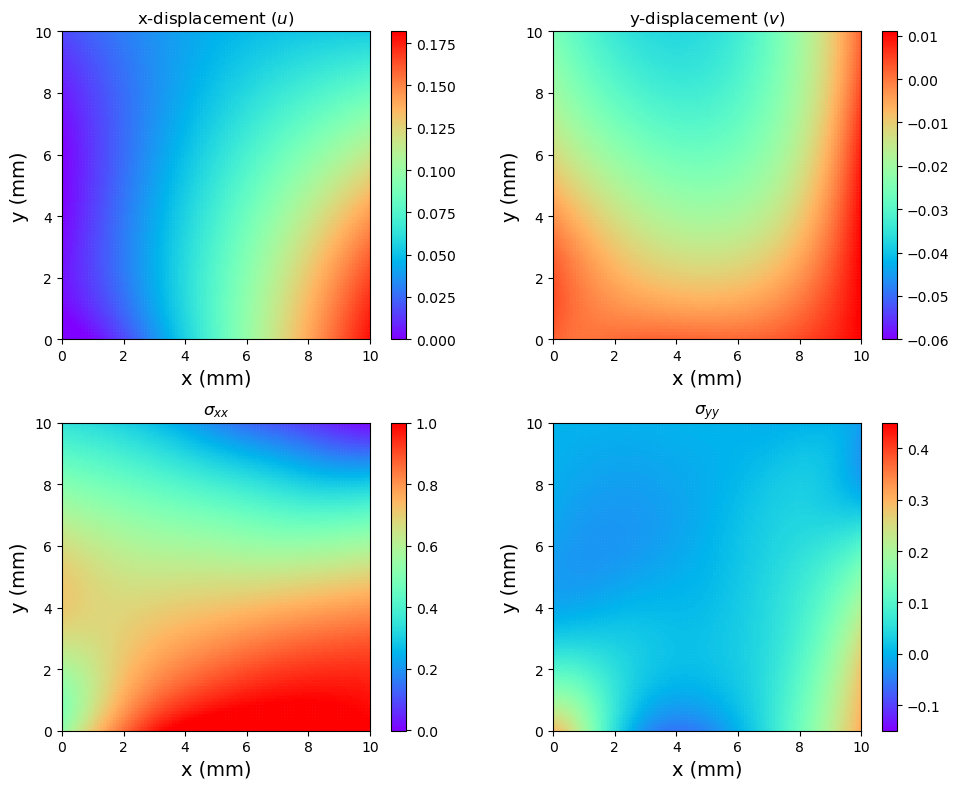

In [17]:
samples = geom.uniform_points(10000)
pde_disp = model.predict(samples)
pde_sg = np.hstack(check_stress(model.net, samples))
pde_result = np.hstack([pde_disp, pde_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.003349 s

Training model...

10000     [7.35e-05, 6.79e-05, 1.40e-05, 3.31e-05, 1.95e-05, 5.55e-06, 6.56e-05, 1.08e-05]    [3.52e-05, 3.81e-05, 1.40e-05, 3.31e-05, 1.95e-05, 5.55e-06, 6.56e-05, 1.08e-05]    []  
12422     [1.74e-06, 1.08e-06, 6.31e-07, 4.70e-07, 4.80e-07, 1.13e-07, 2.95e-07, 1.37e-07]    [1.24e-06, 9.12e-07, 6.31e-07, 4.70e-07, 4.80e-07, 1.13e-07, 2.95e-07, 1.37e-07]    []  

Best model at step 12422:
  train loss: 4.94e-06
  test loss: 4.28e-06
  test metric: []

'train' took 857.258816 s



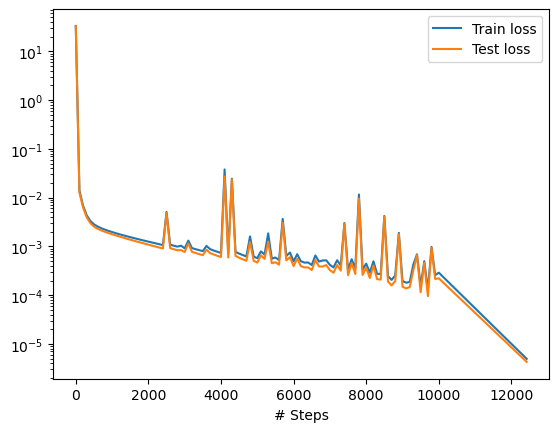

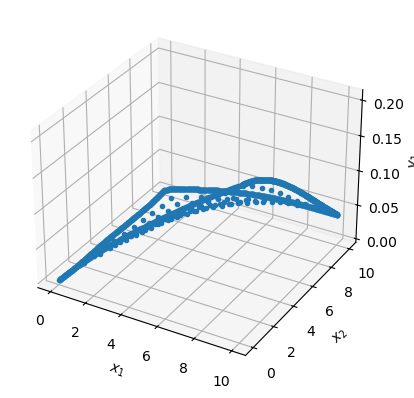

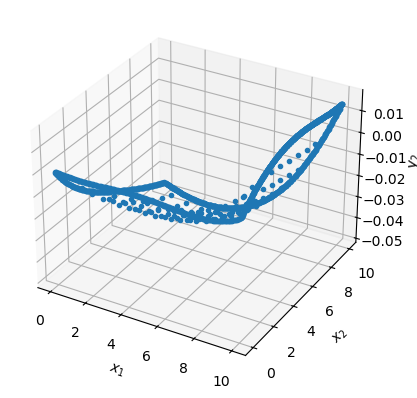

In [19]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam + L-BFGS)

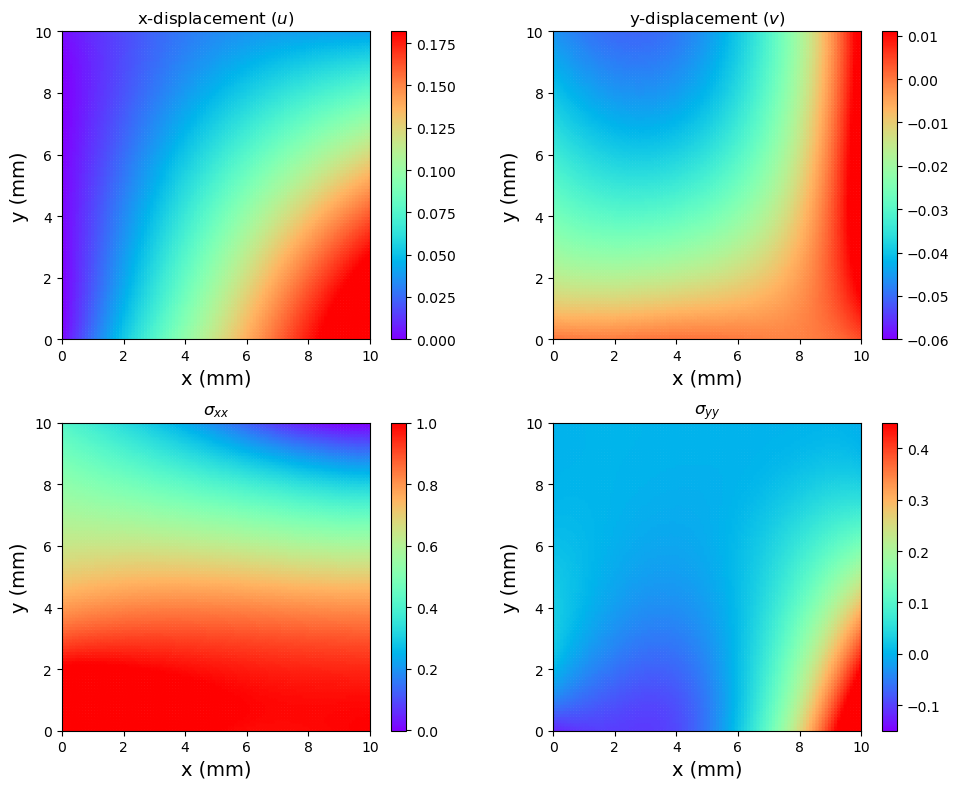

In [20]:
samples = geom.uniform_points(10000)
pde_disp = model.predict(samples)
pde_sg = np.hstack(check_stress(model.net, samples))
pde_result = np.hstack([pde_disp, pde_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Save and Restore

In [44]:
model.predict(samples)

array([[ 0.00119298,  0.00035098],
       [ 0.00088751, -0.00069287],
       [ 0.00061605, -0.00170765],
       ...,
       [ 0.04396373,  0.01430303],
       [ 0.04190397,  0.01428218],
       [ 0.03984903,  0.01427119]], dtype=float32)

In [35]:
model.save('model/pde', verbose=1)

Epoch 12422: saving model to model/pde-12422.ckpt ...



'model/pde-12422.ckpt'

In [36]:
mm = dde.Model(data, net)

In [37]:
mm.restore('model/pde-12422.ckpt')

In [49]:
mm.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.005125 s



In [50]:
mm.predict(samples)

array([[ 0.00119298,  0.00035098],
       [ 0.00088751, -0.00069287],
       [ 0.00061605, -0.00170765],
       ...,
       [ 0.04396373,  0.01430303],
       [ 0.04190397,  0.01428218],
       [ 0.03984903,  0.01427119]], dtype=float32)

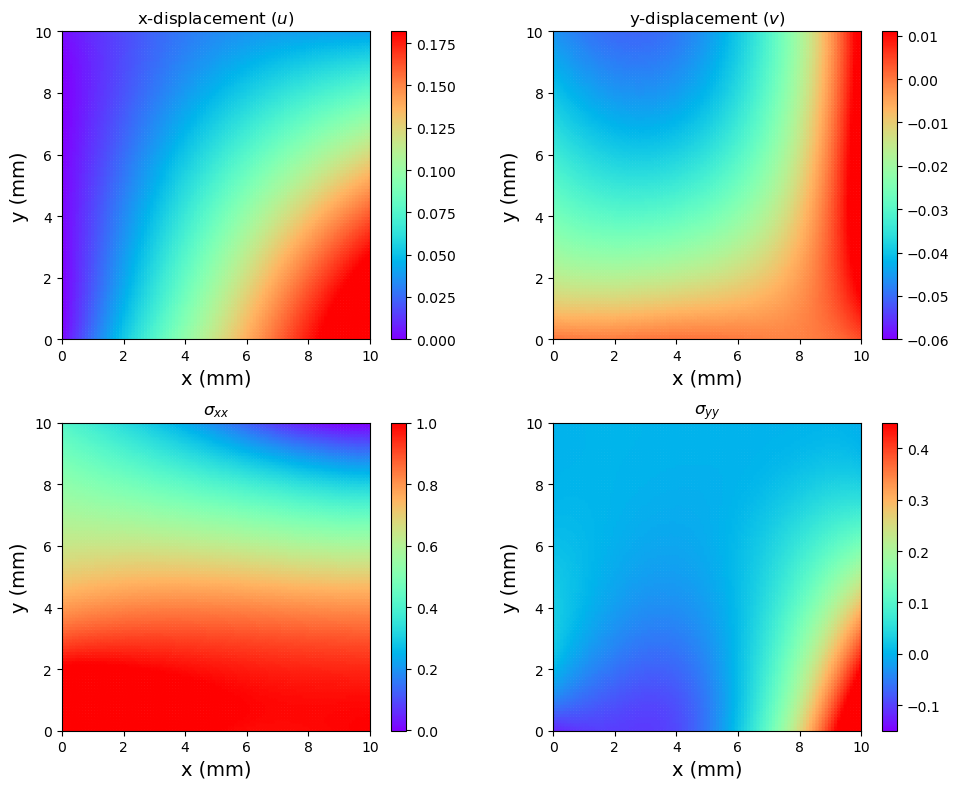

In [51]:
samples = geom.uniform_points(10000)
pde_disp = mm.predict(samples)
pde_sg = np.hstack(check_stress(mm.net, samples))
pde_result = np.hstack([pde_disp, pde_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()